# Create the dataset for the model, calculate statistics for each player

### Import Libraries

In [15]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import os
from collections import defaultdict, deque

pd.set_option('display.max_columns', None)

In [3]:
clean_data = pd.read_csv("../data/cleanedDataset.csv")
clean_data

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,p1_id,p1_seed,p1_entry,p1_name,p1_hand,p1_ht,p1_ioc,p1_age,p2_id,p2_seed,p2_entry,p2_name,p2_hand,p2_ht,p2_ioc,p2_age,score,best_of,round,minutes,p1_ace,p1_df,p1_svpt,p1_1stIn,p1_1stWon,p1_2ndWon,p1_SvGms,p1_bpSaved,p1_bpFaced,p2_ace,p2_df,p2_svpt,p2_1stIn,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,RESULT
0,1991-301,Auckland,Hard,32,A,19910107,1,101746,NaN,NaN,Renzo Furlan,R,175.0,ITA,20.6,101142,1.0,NaN,Emilio Sanchez,R,180.0,ESP,25.6,6-4 6-1,3,R32,63.0,3.0,0.0,46.0,30.0,17.0,7.0,8.0,2.0,6.0,1.0,0.0,53.0,37.0,30.0,7.0,9.0,5.0,6.0,78.0,459.0,9.0,1487.0,0
1,1991-301,Auckland,Hard,32,A,19910107,2,100587,NaN,WC,Steve Guy,R,188.0,NZL,31.8,101613,NaN,Q,Malivai Washington,R,180.0,USA,21.5,6-3 6-2,3,R32,72.0,4.0,7.0,56.0,30.0,22.0,6.0,8.0,7.0,11.0,5.0,1.0,56.0,25.0,17.0,20.0,9.0,1.0,2.0,220.0,114.0,94.0,371.0,0
2,1991-301,Auckland,Hard,32,A,19910107,3,101601,NaN,WC,Brett Steven,R,185.0,NZL,21.6,101179,NaN,NaN,Jean Philippe Fleurian,R,185.0,FRA,25.3,2-6 6-1 6-2,3,R32,101.0,1.0,3.0,68.0,43.0,24.0,14.0,11.0,4.0,8.0,2.0,4.0,80.0,55.0,35.0,16.0,12.0,2.0,4.0,212.0,116.0,77.0,468.0,0
3,1991-301,Auckland,Hard,32,A,19910107,4,101332,8.0,NaN,Gilad Bloom,L,173.0,ISR,23.8,101117,NaN,NaN,Eric Jelen,R,180.0,GER,25.8,6-3 1-6 6-4,3,R32,108.0,3.0,2.0,96.0,61.0,38.0,15.0,13.0,8.0,12.0,0.0,1.0,82.0,55.0,35.0,14.0,13.0,6.0,10.0,72.0,483.0,65.0,502.0,0
4,1991-301,Auckland,Hard,32,A,19910107,5,101901,NaN,Q,Chuck Adams,R,185.0,USA,19.7,101735,3.0,NaN,Richard Fromberg,R,196.0,AUS,20.6,6-3 6-4,3,R32,65.0,4.0,4.0,65.0,46.0,34.0,12.0,10.0,2.0,2.0,1.0,3.0,49.0,25.0,21.0,12.0,9.0,4.0,6.0,190.0,142.0,28.0,876.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95370,2024-M-DC-2024-WG2-PO-TOG-INA-01,Davis Cup WG2 PO: TOG vs INA,Hard,4,D,20240203,4,133933,NaN,NaN,Thomas Yaka Kofi Setodji,R,183.0,TOG,28.2,207134,NaN,NaN,Fitriadi M Rifqi,R,175.0,INA,25.0,6-2 6-3,3,RR,87.0,2.0,1.0,50.0,35.0,19.0,5.0,8.0,5.0,9.0,1.0,2.0,52.0,32.0,25.0,11.0,9.0,2.0,3.0,819.0,24.0,569.0,64.0,0
95371,2024-M-DC-2024-WG2-PO-TUN-CRC-01,Davis Cup WG2 PO: TUN vs CRC,Hard,4,D,20240202,1,132374,NaN,NaN,Jesse Flores,R,188.0,CRC,28.8,121411,NaN,NaN,Moez Echargui,R,178.0,TUN,31.0,6-2 6-3,3,RR,65.0,3.0,2.0,49.0,30.0,17.0,9.0,8.0,2.0,5.0,4.0,2.0,56.0,35.0,30.0,11.0,9.0,4.0,4.0,900.0,18.0,279.0,205.0,0
95372,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,1,208364,NaN,NaN,Franco Roncadelli,L,185.0,URU,23.9,209943,NaN,NaN,Ilya Snitari,R,188.0,MDA,21.8,4-6 6-1 6-1,3,RR,137.0,1.0,2.0,74.0,50.0,31.0,13.0,12.0,5.0,9.0,0.0,5.0,92.0,52.0,24.0,18.0,12.0,8.0,16.0,616.0,55.0,740.0,34.0,1
95373,2024-M-DC-2024-WG2-PO-URU-MDA-01,Davis Cup WG2 PO: URU vs MDA,Clay,4,D,20240203,4,105430,NaN,NaN,Radu Albot,R,175.0,MDA,34.2,208364,NaN,NaN,Franco Roncadelli,L,185.0,URU,23.9,6-3 6-1,3,RR,95.0,2.0,1.0,50.0,30.0,19.0,14.0,8.0,3.0,4.0,1.0,1.0,82.0,66.0,33.0,6.0,8.0,6.0,11.0,136.0,489.0,616.0,55.0,1


### Create the dataset, calculate statistics for each player

In [12]:
from utils.updateStats import getStats, updateStats, createStats

final_dataset = []
prev_stats = createStats()

# Iterate through each row in clean_data
for index, row in tqdm(clean_data.iterrows(), total=len(clean_data)):
    player1 = {
        "ID": row["p1_id"],
        "ATP_POINTS": row["p1_rank_points"],
        "ATP_RANK": row["p1_rank"],
        "AGE": row["p1_age"],
        "HEIGHT": row["p1_ht"],
    }

    player2 = {
        "ID": row["p2_id"],
        "ATP_POINTS": row["p2_rank_points"],
        "ATP_RANK": row["p2_rank"],
        "AGE": row["p2_age"],
        "HEIGHT": row["p2_ht"],
    }

    match = {
        "BEST_OF": row["best_of"],
        "DRAW_SIZE": row["draw_size"],
        "SURFACE": row["surface"],
    }
    
    # Call getStatsPlayers function
    output = getStats(player1, player2, match, prev_stats)

    # Append sorted stats to final dataset
    match_data = dict(sorted(output.items()))
    match_data["RESULT"] = row.RESULT
    final_dataset.append(match_data)

    # update stats
    prev_stats = updateStats(row, prev_stats)


# Convert final dataset to DataFrame
final_dataset = pd.DataFrame(final_dataset)

100%|██████████| 95375/95375 [02:33<00:00, 619.41it/s]


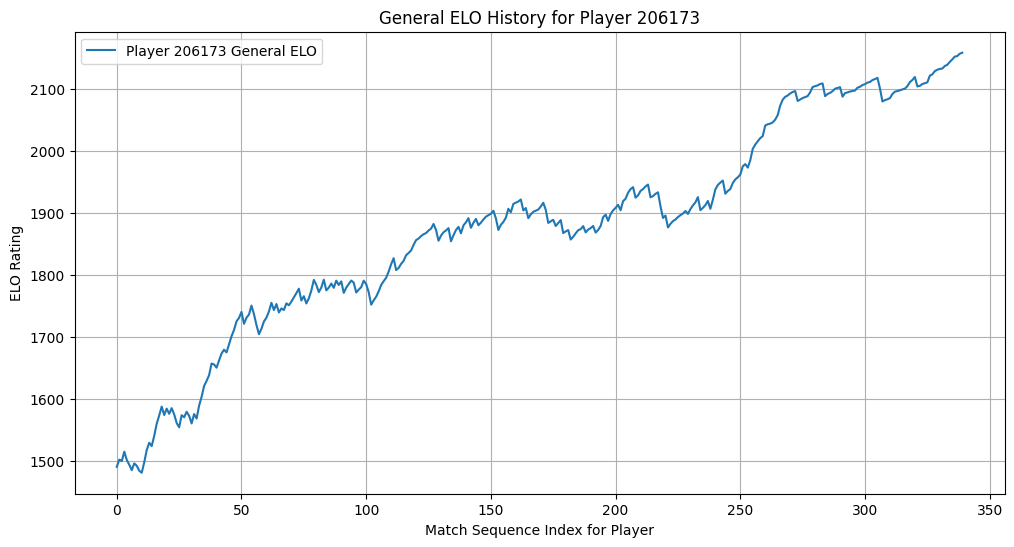

<Figure size 1500x800 with 0 Axes>

In [13]:
player_id_to_plot = 206173 # Replace with an actual player ID from your dataset

# Plot General ELO History
if player_id_to_plot in prev_stats["elo_history_players"]:
    general_elo_history = list(prev_stats["elo_history_players"][player_id_to_plot])
    
    if general_elo_history: # Check if history exists
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(general_elo_history)), general_elo_history, label=f"Player {player_id_to_plot} General ELO")
        plt.xlabel("Match Sequence Index for Player")
        plt.ylabel("ELO Rating")
        plt.title(f"General ELO History for Player {player_id_to_plot}")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"No general ELO history found for Player {player_id_to_plot}")

else:
    print(f"Player {player_id_to_plot} not found in general ELO history records.")


# Plot Surface-Specific ELO History for the same player
plt.figure(figsize=(15, 8))
plotted_any_surface = False

# Determine which surfaces to plot. You can use a fixed list or get from your data.
# Using unique surfaces from your clean_data is more robust.
# Make sure `clean_data` is accessible here or use a predefined list like _defined_surfaces_for_padding.
surfaces_to_plot = clean_data['surface'].unique().tolist() 

In [17]:
def convert_to_json_serializable(data):
    """
    Recursively converts defaultdicts and deques to standard dicts and lists.
    Converts tuple keys in dictionaries to string representations.
    """
    if isinstance(data, defaultdict):
        # Convert defaultdict to dict and recursively process its values
        # Also handle tuple keys by converting them to strings
        return {str(k) if isinstance(k, tuple) else k: convert_to_json_serializable(v) for k, v in data.items()}
    elif isinstance(data, dict):
        # Convert regular dict and recursively process its values
        # Also handle tuple keys by converting them to strings
        return {str(k) if isinstance(k, tuple) else k: convert_to_json_serializable(v) for k, v in data.items()}
    elif isinstance(data, deque):
        # Convert deque to list and recursively process its elements
        return [convert_to_json_serializable(elem) for elem in data]
    elif isinstance(data, list):
        # Recursively process elements of a list
        return [convert_to_json_serializable(elem) for elem in data]
    # Add other type conversions if necessary (e.g., numpy types to Python natives)
    elif hasattr(data, 'item'): # Basic check for numpy numbers
        return data.item()
    return data


In [18]:
print("Converting prev_stats to JSON serializable format...")
# prev_stats is the dictionary populated by your loop
json_compatible_prev_stats = convert_to_json_serializable(prev_stats)
print("Conversion complete.")

# Define a path to save the prev_stats as JSON.
# Adjust this path based on your project structure.
prev_stats_json_output_path = "../data/prev_stats.json" # Example path

# Ensure the target directory exists
os.makedirs(os.path.dirname(prev_stats_json_output_path), exist_ok=True)

print(f"Attempting to save prev_stats to {prev_stats_json_output_path}...")
try:
    with open(prev_stats_json_output_path, "w") as f:
        json.dump(json_compatible_prev_stats, f, indent=2) # indent for readability
    print(f"Successfully saved prev_stats to {prev_stats_json_output_path}")
except Exception as e:
    print(f"Error saving prev_stats as JSON: {e}")
    import traceback
    traceback.print_exc()

Converting prev_stats to JSON serializable format...
Conversion complete.
Attempting to save prev_stats to ../data/prev_stats.json...
Successfully saved prev_stats to ../data/prev_stats.json


In [7]:
final_dataset.iloc[80000:90000]

,AGE_DIFF,ATP_POINTS_DIFF,ATP_RANK_DIFF,BEST_OF,DRAW_SIZE,ELO_DIFF,ELO_GRAD_LAST_100_DIFF,ELO_GRAD_LAST_10_DIFF,ELO_GRAD_LAST_200_DIFF,ELO_GRAD_LAST_25_DIFF,ELO_GRAD_LAST_3_DIFF,ELO_GRAD_LAST_50_DIFF,ELO_GRAD_LAST_5_DIFF,ELO_SURFACE_DIFF,H2H_DIFF,H2H_SURFACE_DIFF,HEIGHT_DIFF,N_GAMES_DIFF,P_1ST_IN_LAST_100_DIFF,P_1ST_IN_LAST_10_DIFF,P_1ST_IN_LAST_200_DIFF,P_1ST_IN_LAST_25_DIFF,P_1ST_IN_LAST_3_DIFF,P_1ST_IN_LAST_50_DIFF,P_1ST_IN_LAST_5_DIFF,P_1ST_WON_LAST_100_DIFF,P_1ST_WON_LAST_10_DIFF,P_1ST_WON_LAST_200_DIFF,P_1ST_WON_LAST_25_DIFF,P_1ST_WON_LAST_3_DIFF,P_1ST_WON_LAST_50_DIFF,P_1ST_WON_LAST_5_DIFF,P_2ND_WON_LAST_100_DIFF,P_2ND_WON_LAST_10_DIFF,P_2ND_WON_LAST_200_DIFF,P_2ND_WON_LAST_25_DIFF,P_2ND_WON_LAST_3_DIFF,P_2ND_WON_LAST_50_DIFF,P_2ND_WON_LAST_5_DIFF,P_ACE_LAST_100_DIFF,P_ACE_LAST_10_DIFF,P_ACE_LAST_200_DIFF,P_ACE_LAST_25_DIFF,P_ACE_LAST_3_DIFF,P_ACE_LAST_50_DIFF,P_ACE_LAST_5_DIFF,P_BP_SAVED_LAST_100_DIFF,P_BP_SAVED_LAST_10_DIFF,P_BP_SAVED_LAST_200_DIFF,P_BP_SAVED_LAST_25_DIFF,P_BP_SAVED_LAST_3_DIFF,P_BP_SAVED_LAST_50_DIFF,P_BP_SAVED_LAST_5_DIFF,P_DF_LAST_100_DIFF,P_DF_LAST_10_DIFF,P_DF_LAST_200_DIFF,P_DF_LAST_25_DIFF,P_DF_LAST_3_DIFF,P_DF_LAST_50_DIFF,P_DF_LAST_5_DIFF,WIN_LAST_100_DIFF,WIN_LAST_10_DIFF,WIN_LAST_200_DIFF,WIN_LAST_25_DIFF,WIN_LAST_3_DIFF,WIN_LAST_50_DIFF,WIN_LAST_5_DIFF,RESULT
80000,-9.0,841.0,-32.0,3,64,184.022575,-0.002058,-0.054545,0.000000,-0.004615,0.0,-0.003313,0.0,184.605287,0,0,0.0,44,3.652874,4.886677,1.335620,2.849790,6.121021,1.812696,5.191405,1.978027,-1.394833,1.014764,0.048358,0.300859,0.620852,-2.438532,9.236347,6.877268,6.839575,6.841027,12.777386,7.468817,8.126696,0.494546,-4.103362,-0.381343,-0.217938,-7.909074,-0.008587,-4.510451,7.032683,-1.775719,6.514740,-4.760504,11.489899,-1.269394,-1.439394,-4.224958,-3.562975,-3.205509,-4.444903,0.010071,-3.660038,-1.509037,21,1,0,2,0,7,0,1
80001,-8.4,-4170.0,10.0,3,64,-220.387231,0.002604,0.012121,-0.000458,0.017692,0.0,0.008307,0.0,-257.530978,-3,-3,-7.0,-841,-1.508813,-0.530155,-2.326722,-2.306902,-1.034585,-2.504935,2.624205,-9.850421,-4.354268,-8.900513,-9.896084,-7.817334,-10.699404,-3.164738,-6.912311,-0.677347,-5.624917,-4.467694,8.493338,-6.620545,5.775726,-8.150531,-4.196880,-7.533149,-6.633118,-3.024161,-7.707812,-0.050255,-2.601246,-16.478843,-5.056271,-10.277518,-2.020202,-10.252418,-26.545455,0.435816,-1.505794,0.570519,0.530280,0.165474,0.484872,-1.170738,-22,0,-30,-3,0,-9,0,0
80002,-9.9,-1690.0,2.0,3,64,-202.831154,-0.001788,0.084848,0.001364,-0.003846,0.0,-0.015990,0.1,-310.264281,1,0,10.0,-708,-2.241283,-5.229770,-2.770919,-3.412494,-10.092791,-2.345259,-6.777775,1.305443,-0.687441,-0.046172,0.196950,-4.061257,0.868513,-1.056150,-0.602446,-5.897621,-3.036140,-3.267794,3.343455,0.527568,-3.188732,3.872143,3.994266,3.463544,1.045328,0.490653,2.058985,3.005826,-4.386463,-23.238095,-2.844200,-15.301374,4.444444,-8.772285,-20.666667,0.951454,1.683183,1.449574,1.252871,0.745937,0.422526,1.188797,-6,-4,-28,-6,0,-1,-1,0
80003,15.3,5085.0,-17.0,3,64,311.774474,-0.003696,-0.030303,-0.000945,-0.009231,0.0,-0.004034,-0.1,387.939165,1,2,-3.0,1149,-0.493676,-2.161520,1.221109,1.753900,-1.525408,-0.205418,-5.019174,8.015313,3.506986,9.349808,6.118387,-2.265519,7.636057,1.652659,5.201000,-5.340481,6.395903,1.599781,-24.141975,3.117224,-14.206773,4.466240,4.281243,4.805503,3.028896,-0.883370,3.582026,2.609052,2.348282,8.667027,6.345811,9.595382,-10.656566,8.533880,2.318182,-0.682522,0.336859,-0.707924,-0.475068,-0.024985,-0.587743,-0.303428,30,1,66,4,0,10,0,0
80004,9.5,4630.0,-16.0,3,64,286.088219,-0.000120,-0.078788,-0.001874,-0.004615,0.0,0.011669,0.0,373.836292,2,0,0.0,748,3.542230,2.191832,4.169101,3.464667,3.782163,4.101749,-0.417519,0.839062,4.067984,2.773834,0.498122,11.006049,0.865281,3.497071,-0.792528,-2.171116,3.574301,-1.653272,-10.645558,-1.715422,-13.116162,-2.079830,-2.723638,-1.126541,-2.559244,-5.150770,-1.904746,-4.352713,1.403582,6.886364,3.607818,4.276190,31.565657,3.785750,23.106061,0.037870,-0.060290,-0.058290,0.513097,0.4041

### Save the final dataset in a CSV

In [8]:
final_dataset.to_csv("../data/finalDataset.csv", index=False)
